In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
import matplotlib as mpl
from pandas import DataFrame, Series
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression, SequentialFeatureSelector, mutual_info_regression
from scipy.stats import t, pearsonr
import statsmodels.api as sm
from utils import load_boston_housing_market, forward_select

plt.ioff()
pd.set_option('display.max_columns', None)  # Print all the columns in the dataframe
pd.set_option('display.expand_frame_repr', False)  # Prevents line breaks while printing the dataframe
mpl.rcParams['figure.figsize'] = (6 * 1.618, 6)

# Set the default resolution for plots on screen
display_res = (2560, 1440)  # Display resolution in pixels, h x v
diagonal_in = 27  # Display diagonal in inches
res_dpi = (display_res[0] ** 2 + display_res[1] ** 2) ** .5 / diagonal_in
plt.rcParams['figure.dpi'] = res_dpi

# By default, display grids in plot
mpl.rcParams['axes.grid'] = True

# Set display formatting options for numbers with Pandas
pd.options.display.float_format = '{:,.3f}'.format

This is an exploration of linear regression, and different tools available to solve it with Python.
The dataset of choice is the [Boston Housing Prices](http://lib.stat.cmu.edu/datasets/boston).

Here for reference the meaning of the variables, taken from the [dataset description](https://bit.ly/3yqTZnL):
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)\^2 where Bk is the proportion of blacks by town \[Note: dropped from this dataset\]
- LSTAT - \% lower status of the population
- MEDV - Median value of owner-occupied homes in thousands USD

Feth the dataset from its original source, and load it.

In [31]:
dataset_X, dataset_y, dataset = load_boston_housing_market()

Compute and display basic statistics from the dataset

In [32]:
n_samples = len(dataset)
n_vars = len(dataset.columns) - 1

print(f'The dataset contains {n_samples} samples, and {n_vars} variables (target not included).')

The dataset contains 506 samples, and 12 variables (target not included).


In [33]:
print('The first 5 samples from the dataset')
print(dataset.head())

The first 5 samples from the dataset
   CRIM     ZN  INDUS  CHAS   NOX    RM    AGE   DIS   RAD     TAX  PTRATIO  LSTAT   MEDV
0 0.006 18.000  2.310 0.000 0.538 6.575 65.200 4.090 1.000 296.000   15.300  4.980 24.000
1 0.027  0.000  7.070 0.000 0.469 6.421 78.900 4.967 2.000 242.000   17.800  9.140 21.600
2 0.027  0.000  7.070 0.000 0.469 7.185 61.100 4.967 2.000 242.000   17.800  4.030 34.700
3 0.032  0.000  2.180 0.000 0.458 6.998 45.800 6.062 3.000 222.000   18.700  2.940 33.400
4 0.069  0.000  2.180 0.000 0.458 7.147 54.200 6.062 3.000 222.000   18.700  5.330 36.200


In [34]:
print('Dataset stats')
print(dataset.describe().T)

Dataset stats
          count    mean     std     min     25%     50%     75%     max
CRIM    506.000   3.614   8.602   0.006   0.082   0.257   3.677  88.976
ZN      506.000  11.364  23.322   0.000   0.000   0.000  12.500 100.000
INDUS   506.000  11.137   6.860   0.460   5.190   9.690  18.100  27.740
CHAS    506.000   0.069   0.254   0.000   0.000   0.000   0.000   1.000
NOX     506.000   0.555   0.116   0.385   0.449   0.538   0.624   0.871
RM      506.000   6.285   0.703   3.561   5.885   6.208   6.623   8.780
AGE     506.000  68.575  28.149   2.900  45.025  77.500  94.075 100.000
DIS     506.000   3.795   2.106   1.130   2.100   3.207   5.188  12.127
RAD     506.000   9.549   8.707   1.000   4.000   5.000  24.000  24.000
TAX     506.000 408.237 168.537 187.000 279.000 330.000 666.000 711.000
PTRATIO 506.000  18.456   2.165  12.600  17.400  19.050  20.200  22.000
LSTAT   506.000  12.653   7.141   1.730   6.950  11.360  16.955  37.970
MEDV    506.000  22.533   9.197   5.000  17.025  2

In [35]:
print('Count of unique values for each variable')
counts = dataset.nunique()
print(counts.to_frame().T)

Count of unique values for each variable
   CRIM  ZN  INDUS  CHAS  NOX   RM  AGE  DIS  RAD  TAX  PTRATIO  LSTAT  MEDV
0   504  26     76     2   81  446  356  412    9   66       46    455   229


In [36]:
print('Count number of NaN for each variable')
print(dataset.isna().sum().to_frame().T)

Count number of NaN for each variable
   CRIM  ZN  INDUS  CHAS  NOX  RM  AGE  DIS  RAD  TAX  PTRATIO  LSTAT  MEDV
0     0   0      0     0    0   0    0    0    0    0        0      0     0


Draw box plots for every variable, side by side (each has its own scale).

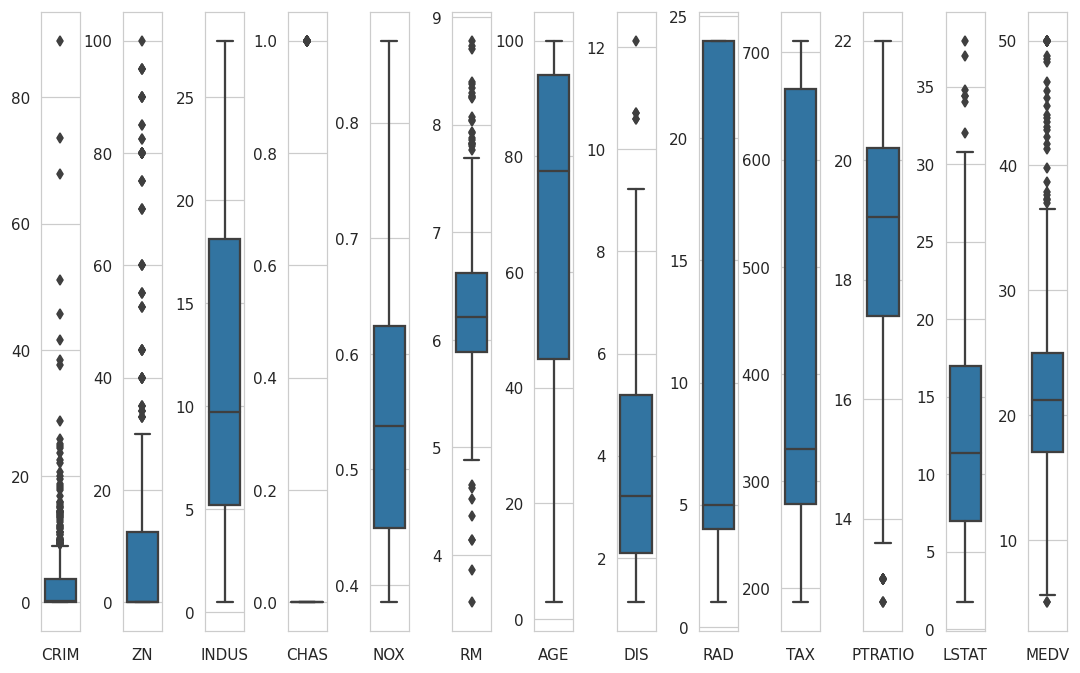

In [37]:
fig, axes = plt.subplots(1, n_vars + 1)
# fig.subplots_adjust(wspace=.25)
for i, col in enumerate(dataset.columns):
    bplot = sns.boxplot(y=dataset[col], ax=axes[i])
    bplot.set(ylabel=None)
    bplot.set(xlabel=col)
fig.tight_layout(pad=0, w_pad=.25, h_pad=0)

We start with a simple (that is, uni-variate) linear regression of MEDV against LSTAT.

Plotting the distribution of LSTAT values

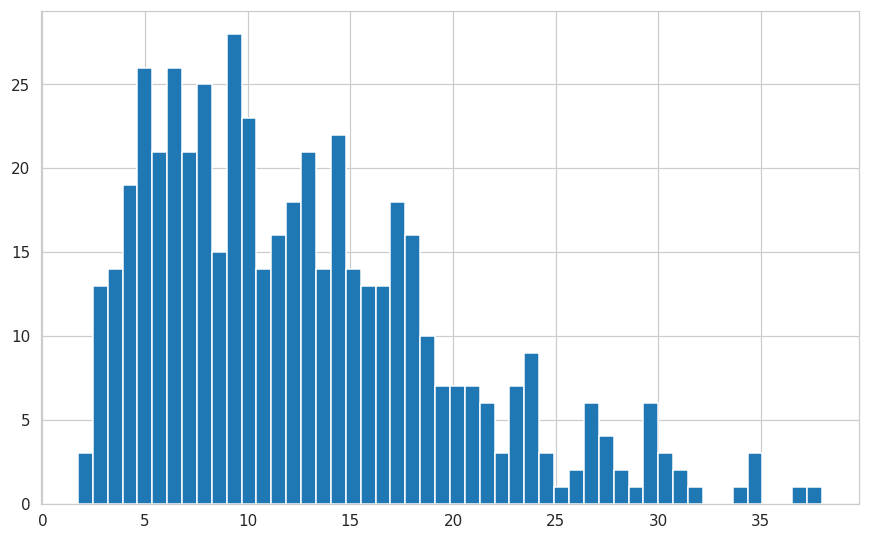

In [38]:
plt.hist(dataset['LSTAT'], bins=50);

# Simple (Univariate) Linear Regression

 We perform a linear regression of MEDV against LSTAT and output the result. We start from the assumption that the  relationship between the predictor $X$ and the prediction $Y$ is in the form

$$Y=\beta_0+\beta_1 X+\epsilon$$

where $\beta_0$ is the intercept of the linear relationship, $\beta_1$ is its slope, and $\epsilon$ is the overall error in the prediction. The latter encompasses several issues:
- the relationship under study is not actually linear; assuming it linear introduces errors;
- there are additional variables, beside the predictor, that influence the prediction; ignoring them introduces errors;
- there are measurement errors, and other errors intervening when gathering measurements for predictor and prediction.

Generally speaking, we are unable to observe the whole population, therefore we are unable to determine the true values for the coefficients of the population regression line, $\beta_0$ and $\beta_1$. However, we have available a sample of measurements from the population, and will use it to fit the linear regression and find unbiased estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ of the population regression coefficients.

In [39]:
X, y = dataset['LSTAT'].values.reshape(-1, 1), dataset['MEDV'].values
model: LinearRegression = LinearRegression().fit(X, y)
y_pred = model.predict(X=X)
slope = model.coef_[0]
intercept = model.intercept_
print(f'\nMEDV linear regression against LSTAT has coefficient (slope) {slope} and intercept {intercept}')


MEDV linear regression against LSTAT has coefficient (slope) -0.9500493537579906 and intercept 34.5538408793831


Plot the linear regression against the data.

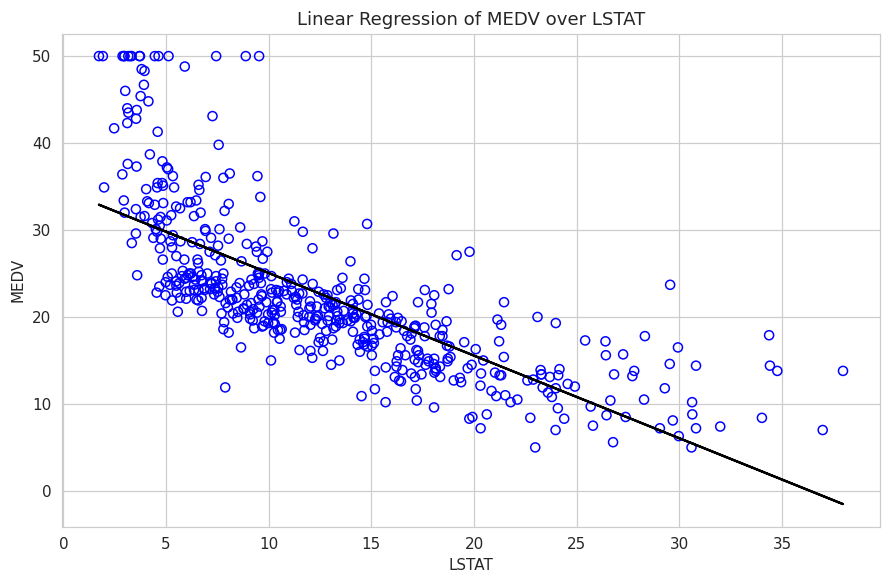

In [40]:
_, ax = plt.subplots()
ax.scatter(X, y, facecolor='none', edgecolor='blue')
ax.plot(X, y_pred, color='black')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
ax.set_title('Linear Regression of MEDV over LSTAT');

## How accurate are the coefficient estimates?

A convenience of linear regression is that it allows to assess the accuracy of the results using well understood statistical tools, like confidence intervals and p-values. We start with determining the standard error $SE$ for both coefficient estimates:

$$ SE(\hat{\beta_0})^2 = \sigma^2[\frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^n(x_i-\bar x)^2] $$

$$ SE(\hat{\beta_1})^2 = \frac{\sigma^2}{\sum_{i=1}^n(x_i-\bar x)^2} $$

which holds exactly when the errors $\epsilon_i$ for each observation are uncorreleted and all with variance $\sigma^2$.
Unfortunately we don't know $\sigma^2$, but we can estimate it as the square of the residual standard error, $RSE^2$, where

$$RSE=\sqrt{\frac{RSS}{n-2}}$$

Then we can base the confidence interval on a t statistic.

In [41]:
# Compute the standard error for the slope, needed to determine the confidence interval
rss = np.sum(np.power(y - y_pred, 2))  # Residual sum of squares
rse = (rss / (n_samples - 2)) ** .5  # Residual standard error
X_mean = np.mean(X)
se_slope = rse / np.sqrt(np.sum(np.power(X - X_mean, 2)))  # Standard error of the slope
print(f'RSS={rss:.3f}; RSE={rse:.3f} on {n_samples - 2} degrees of freedom.')
print(f'Standard error on slope {se_slope:.3f}')

slope_ci = t.interval(alpha=.95, df=n_samples-2, loc=slope, scale= se_slope)  # Get the confidence interval
print(f'The 95% CI for the slope is [{slope_ci[0]:.3f}, {slope_ci[1]:.3f}]')

RSS=19472.381; RSE=6.216 on 504 degrees of freedom.
Standard error on slope 0.039
The 95% CI for the slope is [-1.026, -0.874]


## How good is the model overall?
The overall quality of the fit for liner regression can be assessed via its residual standard error (RSE) and it $R^2$ statistic.

The RSE is in the same measurement unit as the predictions, and can therefore be compared to them. It has already been computed above, to find a confidence interval for the slope. It's value is

In [42]:
f'RSE = {rse:.3f}'

'RSE = 6.216'

The RSE is also an estimate of the standard deviation of the error $\epsilon$, that is the error that intervenes when replacing the true values $Y$ with their predictions $\hat Y$.

An alternative measure for the goodness of fit is the $R^2$ statistic, which is adimensional, and always between 0 and 1 included; we can make sense of it, and tell how good or bad it is, without having to compare it against the magnitude of the predictions. It is defined as

$$ R^2 = \frac{TSS-RSS}{TSS} = 1-\frac{RSS}{TSS}$$

where TSS is the total sum of squares.

$$ TSS = \sum_i (y_i, \bar y)^2 $$

The total sum of squares is the total squared error that we would obtain by predicting every $Y$ with the average of the values in the dataset $\bar Y$, that is, taking $\hat Y = \bar Y$ whatever the X. The latter can be regarded as a baseline linear model, which is trivial to obtain, and that we try to improve upon with an ordinary least squares fit. The RSS of our fit cannot be worse than TSS, and the smaller it is (the closer to 0), the better, as $0 \le RSS \le TSS$.

In other words, TSS is the value for the RSS of the null predictor model, the model when $\hat \beta_1=0$ and every prediction is $\bar Y$.

The ratio $\frac{RSS}{TSS}$ can be seen as the reciprocal of the improvement that our fit provides over the null predictor model: the greater the improvement in total squares error, the smaller the ratio.
The statistic $R^2$ therefore measures the goodness of our fit against the trivial model $\hat Y = \bar Y$ for every $X$.

In the case of simple linear regression, it is also possible to show that
$$R^2 = [Cor(X, Y)]^2 $$
The $R^2$ statistic is also the square of Pearson correlation in the dataset between predictors $X$ and the corresponding values $Y$. If we take $R^2$ as goodness of fit, then the OLS regression can do as good as allowed by the correlation in the dataset.



In [43]:
r2 = model.score(X, y)
cor = pearsonr(np.squeeze(X), y)
f'R-squared={r2:.3f}   Correlation squared={cor[0]**2:.3f}'

'R-squared=0.544   Correlation squared=0.544'

TODO: add the adjusted R-square here.

Let's do it again, this time with Statsmodel.

In [44]:
X_exog = sm.add_constant(X, prepend=False)  # TODO this is needed for correct result, but why?
model_sm = sm.OLS(y, X_exog)
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 25 May 2022   Prob (F-statistic):           5.08e-88
Time:                        10:44:10   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9500      0.039    -24.528      0.0

## Is there a relationship between the predictor and predicted values?

We want to find out if there is a relationship between MEDV and LSTAT. The scatterplot indicates so, in spite of outliers toward high MEDV values; however, more formally, we want to test the null hypothesis $H_0$:
- There is no relationship between MEDV and LSTAT

More formally, we test the null hypothesis that the slope of the linear regression on the whole population is zero:
$$H_0: \beta_1=0$$

versus

$$H_1: \beta_1\neq 0$$

Assuming $H_0$ to be valid, the $t$-statistic has a $t$-distribution with $n-2$ degrees of freedom:

$$t=\frac{\hat \beta_1 -0}{SE(\hat \beta_1)} ∼ t(n-2)$$

The test can then be performed by computing the $p$-value, that is the probability that the $t$-statistic assumes a value no less than $|t|$ when the null hypothesis is true ($\beta_1 = 0$). We reject the null hypothesis when the $p$-value is below a given threshold, say 5%.

The summary of the linear regression made with Statsmodels above reports **a $p$-value which is essentially 0, giving us a high confidence in rejecting $H_0$, and believing there is a relationship between MEDV and LSTAT**.

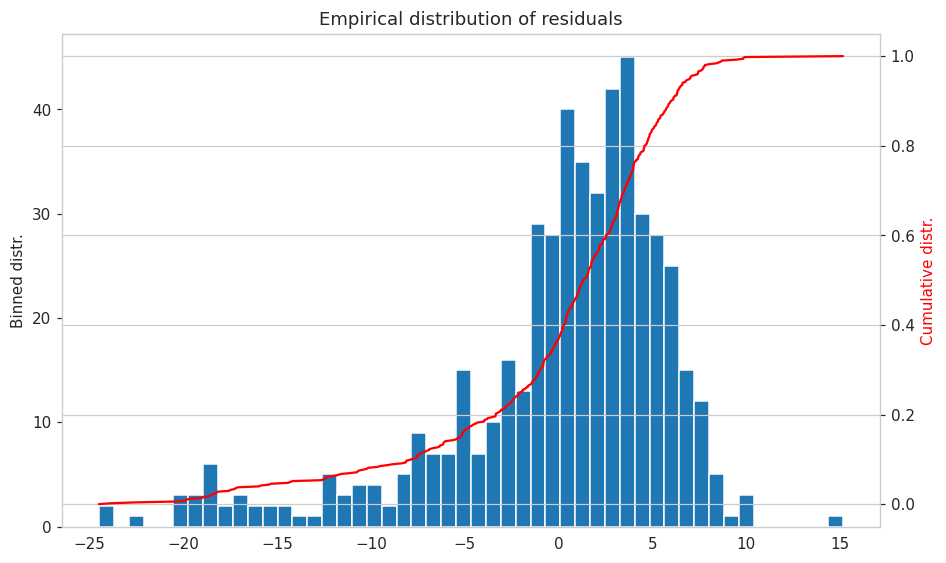

In [45]:
residuals = y_pred - y
_, ax = plt.subplots()
ax.set_title('Empirical distribution of residuals')
ax.set_ylabel('Binned distr.')
ax.hist(residuals, 50)
ax.grid(visible=False)
sorted_residuals = np.sort(residuals)
cum_prob = 1. * np.arange(len(sorted_residuals)) / float(len(sorted_residuals) - 1)
# prob_dens = cum_prob /
ax2 = ax.twinx()
ax2.set_ylabel('Cumulative distr.', color='red')
ax2.plot(sorted_residuals, cum_prob, color='red');

## Given the predictor values, what response value should we predict, and how accurate is the prediction?

Once the model has been fit, and therefore the coefficients $\beta_i$ have been calculated, predictions can be easily computed, just filling the predictor values $X=(x_1, ..., x_p)$ in

$$\hat Y = \hat f(X) = \hat\beta_0 +\hat\beta_1 x_1 + ... + \hat\beta_p x_p $$

(In the case of simple linear regression, $p=1$).

We want to know how reliable $\hat Y$ is a prediction for

$$Y=f(X) = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p$$

There are three kind of errors that intervene, when we do the prediction.
1. The model is an approximation of reality, and our assumption that the phenomenon we observe is linear a simplification. This introduces a reducible error, called the model bias; below we will ignore that error.
2. We cannot compute the coefficients $\beta_i$ for the linear regression over the whole population, therefore we make estimates $\hat \beta_i$ from a sample of the population; this introduces an error in the calculation of the prediction $\hat Y$. This is another reducible error, it can be improved by taking a larger sample.
3. Even if we could reduce the other two errors to zero, there is still an irreducible, random error $\epsilon$ in the model. This may be due to measurement errors, to variables that influence the prediction but that we didn't list among the predictors, etc.

It is possible to construct *confidence intervals* for the prediction, that take into account the second kind of error, and *prediction intervals*, that take into account the second and third kind of errors.

A *confidence interval* of 95% tells us that, if we extracted many (independent) datasets from the same population, and used them to build as many linear regressions, the confidence interval would contain the true value $f(X)$ around 95% of the times. This is basically the uncertainty due to the fact that we use estimates $\hat \beta_i$ instead of the true parameters $\beta_i$.

A *prediction interval* of 95% tells us that, if we repeated the linear regression based on multiple (independent) datasets taken from the population, the value of $f(x)+\epsilon$ would fall within the confidence interval around 95% of the times.

It follows that the prediction interval is wider than the confidence interval, but both are centered on the same prediction value$\hat Y$.

In the case of simple linear regression, it is possible to plot the confidence and prediction intervals as bands around the regression line.

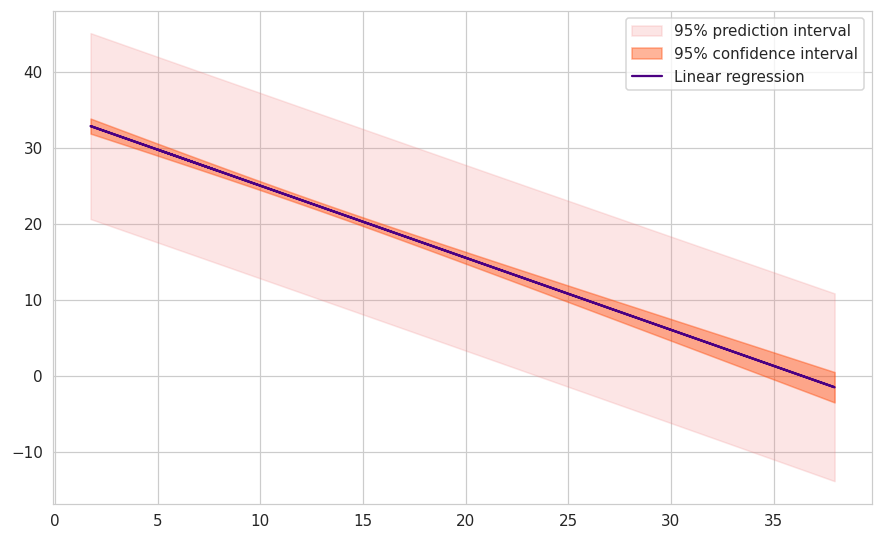

In [46]:
def sort_based_on_another(s, x):
    return s.to_numpy()[np.squeeze(x).argsort()]

y_pred = res.get_prediction(X_exog)
summary = y_pred.summary_frame(alpha=0.05)
fig, ax = plt.subplots()
# fill_between(x, y1, y2) here below assumes that points are listed in (x, y1, y2) left-to-right, in order to provide the desired plot
obs_ci_upper = sort_based_on_another(summary['obs_ci_upper'], X)
obs_ci_lower = sort_based_on_another(summary['obs_ci_lower'], X)
mean_ci_upper = sort_based_on_another(summary['mean_ci_upper'], X)
mean_ci_lower = sort_based_on_another(summary['mean_ci_lower'], X)
sorted_X= np.sort(np.squeeze(X))
ax.fill_between(sorted_X,obs_ci_upper, obs_ci_lower, alpha =0.2, color='lightcoral', label='95% prediction interval' )
ax.fill_between(sorted_X,mean_ci_upper, mean_ci_lower, alpha =0.4, color='orangered', label='95% confidence interval' )
ax.plot(np.squeeze(X), summary['mean'], color='indigo', label='Linear regression')
ax.legend()

# Multiple (Multivariate) Linear Regression
Now let's do some multivariate regression. We start with computing the coefficients via OLS.

In [47]:
X, y = dataset_X, dataset_y
mv_model: LinearRegression = LinearRegression().fit(X, y)
coeffs = pd.Series(mv_model.coef_, index=mv_model.feature_names_in_)
print(f'Coefficients for multivariate linear regression, with intercept {mv_model.intercept_:.3f}')
print(coeffs.to_frame().T)

Coefficients for multivariate linear regression, with intercept 41.617
    CRIM    ZN  INDUS  CHAS     NOX    RM   AGE    DIS   RAD    TAX  PTRATIO  LSTAT
0 -0.121 0.047  0.013 2.840 -18.758 3.658 0.004 -1.491 0.289 -0.013   -0.938 -0.552


In [48]:
y_pred = mv_model.predict(X)
mse = mean_squared_error(y, y_pred)

r2 = mv_model.score(X, y)
rss = np.sum(np.power(y - y_pred, 2))
rse = (rss / (n_samples - 2)) ** .5
print(f'RSS={rss:.3f}; RSE={rse:.3f} on {n_samples - 2} degrees of freedom; R-squared={r2:.3f}')
print('\nThe correlation matrix')
corr_matrix = dataset.corr()
print(corr_matrix)

RSS=11349.419; RSE=4.745 on 504 degrees of freedom; R-squared=0.734

The correlation matrix
          CRIM     ZN  INDUS   CHAS    NOX     RM    AGE    DIS    RAD    TAX  PTRATIO  LSTAT   MEDV
CRIM     1.000 -0.200  0.407 -0.056  0.421 -0.219  0.353 -0.380  0.626  0.583    0.290  0.456 -0.388
ZN      -0.200  1.000 -0.534 -0.043 -0.517  0.312 -0.570  0.664 -0.312 -0.315   -0.392 -0.413  0.360
INDUS    0.407 -0.534  1.000  0.063  0.764 -0.392  0.645 -0.708  0.595  0.721    0.383  0.604 -0.484
CHAS    -0.056 -0.043  0.063  1.000  0.091  0.091  0.087 -0.099 -0.007 -0.036   -0.122 -0.054  0.175
NOX      0.421 -0.517  0.764  0.091  1.000 -0.302  0.731 -0.769  0.611  0.668    0.189  0.591 -0.427
RM      -0.219  0.312 -0.392  0.091 -0.302  1.000 -0.240  0.205 -0.210 -0.292   -0.356 -0.614  0.695
AGE      0.353 -0.570  0.645  0.087  0.731 -0.240  1.000 -0.748  0.456  0.506    0.262  0.602 -0.377
DIS     -0.380  0.664 -0.708 -0.099 -0.769  0.205 -0.748  1.000 -0.495 -0.534   -0.232 -0.497  0.250

Display the correlation matrix as a heatmap with Seaborn

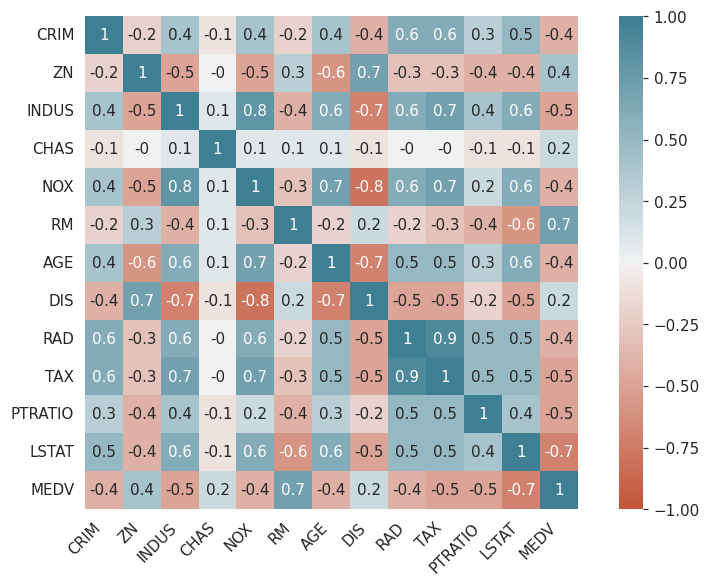

In [49]:
plt.subplots()
corr_matrix_rounded = corr_matrix.round(decimals=1)
ax = sns.heatmap(corr_matrix_rounded,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True,
                 annot=True)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right');

There are several pairs of variables with a comparatively high (positive or negative) correlation, such as RAD and TAX (0.9), NOX and INDUS (0.8), DIS and NOX (-0.8).

In [50]:
# res = f_regression(dataset_X, dataset_y)
res = mutual_info_regression(dataset_X, dataset_y)
print('Howdy')
print(res)

Howdy
[0.33612758 0.19468204 0.46116156 0.03184332 0.45926511 0.52633
 0.31545476 0.2962259  0.21628325 0.35229714 0.43785059 0.66480391]


Let's give it a spin with Statsmodel

In [51]:
print('Summary of multi-variate linear regression with Statsmodel')
X_exog = sm.add_constant(dataset_X, prepend=False)  # TODO this is needed for correct result, but why?
model_sm = sm.OLS(dataset_y, X_exog)
res = model_sm.fit()
print('\n', res.summary())

Summary of multi-variate linear regression with Statsmodel

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 25 May 2022   Prob (F-statistic):          2.23e-133
Time:                        10:44:10   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Statsmdoels' summary give us, among other things, the $t$-statistic and the $p$-value for each of the predictors, relevant to the hypothesis, that the corresponding coefficient is 0 in the linear regression performed on the whole population.

## Some Important questions
We now direct our attention to a few important questions that multiple linear regression can answer, following the track given by Sec. 3.2.2 of [1].

### Is at least one of the predictors useful in predicting the response?

More formally, we want to test the null hypothesis:
- all the coefficients of the multiple linear regression are 0;

versus the alternative:
- at least one of the coefficients in non 0.

The coefficients mentioned above do not include the intercept.

To find out, we will use the F-statistic:
$$
F=\frac{(TSS-RSS)/p}{RSS/(n-p-1)}
$$

Where $TSS=\sum_{}^{} (y_i-\bar y_i^2)$ is the total sum of squares for the response, $RSS$ is the residual sum of squares, $p$ is the number of variables and $n$ the number of samples.

When the null hypothesis is true, the F-statistic is close to 1; otherwise it is greater than 1. In our case:

In [52]:
print(f'The F-statistic is {res.fvalue}')

The F-statistic is 113.54377426836396


One may find the F-statistic to be subjectively much larger than 1, which would lead us to reject $H_0$, but a rigorous test is in order: assuming the errors $\epsilon_i$ are normally distributed, the F-statistic follow an F-distribution [2]. We can use Statsmodels to compute the p-value for the F-statistic:

In [53]:
print(f'P-value for the F-statistic is {res.f_pvalue}')

P-value for the F-statistic is 2.2304199237254893e-133


The p-value is essentially 0, giving us confidence in rejecting $H_0$, and believing that **there is a relationship between response and predictors**.

In [54]:
#TODO better to rely on R squared or F, and why? What's the difference?

### What are the important variables? That make for good predictors.

We perform a forward selection based on the $R^2$ and adjusted $R^2$ statistics

$$Adjusted\ R^2 = 1-\frac{RSS}{TSS} \frac{n-1}{n-1-p}$$

where $p$ is the number of predictors (variables) selected for the model, $n$ is the number of samples, and $TSS$ and $RSS$ are as already defined above.

Predictors are added to the selection one at a time, every time picking the one that increases the resulting $R^2$ statistic the most. The process continues until all variables have been selected, giving a choice of $p$ different models, each containing as many predictors. We then select one of the $p$ models based on their adjusted $R^2$ statistic.

Adding more predictors to the model can only decrease the resulting $RSS$, and therefore increase the resulting $R^2$. However, it also makes the mode more prone to overfitting, which would lead to worse performance of the model on data it hasn't been fitted on. For this reason we select the final model based on the adjusted $R^2$ statistic, which tries to predict the model performance on new data, penalizing the selection of predictors that could make the model overfit.

In [55]:
vars, vars_r2 = forward_select(LinearRegression, dataset_X, dataset_y)
selection = pd.DataFrame({'Variable': vars, 'Adjusted R-squared': vars_r2})
print(selection)

   Variable  Adjusted R-squared
0     LSTAT               0.543
1        RM               0.637
2   PTRATIO               0.677
3       DIS               0.688
4       NOX               0.705
5      CHAS               0.712
6        ZN               0.716
7      CRIM               0.719
8       RAD               0.722
9       TAX               0.729
10      AGE               0.728
11    INDUS               0.728


LSTAT is the first variable that has been selected, the one that single-handedly provides the highest adjusted $R^2$; RM has been selected second, and so on, with INDUS selected last. However, the best model based on its adjusted $R^2$ is the one containing the first 10 selected variables only, up to TAX. Adding more variables after that (AGE, and then INDUS) seems to bring about overfitting, it would improve the $R^2$ score of the model, but likely worsen its performance on data different from the training dataset.

### How well does the model fit the data?

The $R^2$ statistic for the model with all the predictors (computed earlier with Statsmodels) is

In [56]:
f'{res.rsquared:.3f}'

'0.734'

the number above indicates the portion of the variance in the response variable that the model explains. It is a measure of goodness of fit for the model on the training data, which doesn't guarantee the prediction capability of the model on new data (test data), not used to fit it. In fact, overfitting the training data will result in worse performance on the data, or in the wild.

We may use $R^2$ to tune hyper-parameter values, e.g. the number of predictors selected for the model in the forward selection operated above. However, $R^2$ will tend to over-estimate the model performance in the wild, and for this reason we perform that estimate with a different method, like the adjusted $R^2$ statistic or cross-validation.

### Given the predictor values, what response value should we predict, and how accurate is the prediction?

TODO:
- confidence intervals and prediction intervals for the predictions, multivariate case
- diagnostics for residuals and other diagnostics (perhaps in the univariate case)


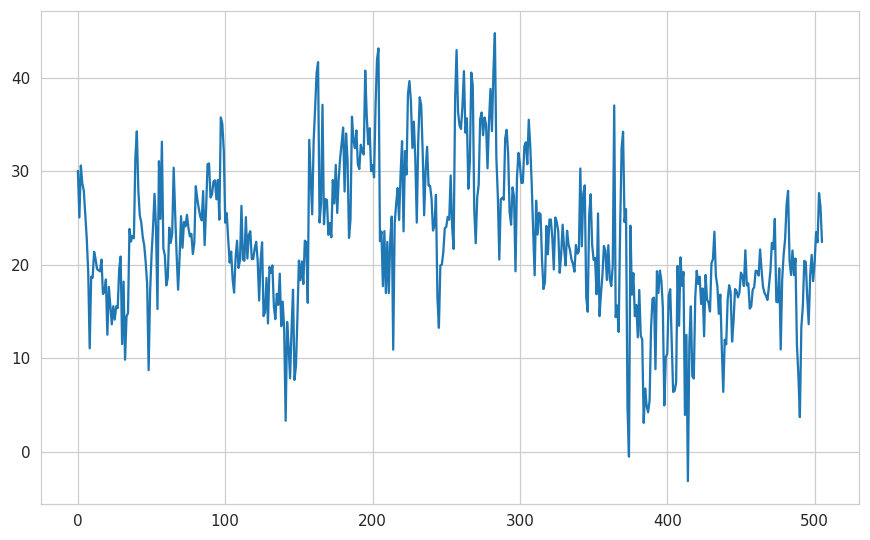

In [57]:
y_pred = res.get_prediction(X_exog)
summary = y_pred.summary_frame(alpha=0.05)
fig, ax = plt.subplots()
ax.plot(summary['mean'])

In [58]:
'''
TODO
- Not clear how to compute and plot the bands of uncertainty around the linear regression, i.e. the CI for a given inference; see y_err above
Note: se2_intercept and se2_slope appear to be correct when compared to R output
- How to compute the confidence intervals for the coefficients, the confidence bands for the regression, and the prediction intervals; what are the assumptions when computing those intervals?
''';